In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2023-03-29 15:47:47.841965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1- Loading data:

1- parse_dates=['Date']: This argument tells pandas to parse the 'Date' column as datetime objects, which makes it easier to work with time-series data. By default, pandas will read the 'Date' column as strings, but specifying parse_dates=['Date'] ensures the dates are correctly interpreted and formatted.

2- index_col='Date': This argument tells pandas to use the 'Date' column as the DataFrame's index. This is particularly useful for time-series data, as it allows for easy slicing and resampling based on time periods. It also ensures that the date information is preserved when performing operations on the DataFrame.

## Processing 

This step is to create a suitable input format for further preprocessing and model training. Let's break down this line into two parts:

1- data['Close'].values: This extracts the 'Close' column from the DataFrame, which represents the closing stock prices, and converts it into a NumPy array.

2- .reshape(-1, 1): This reshapes the array to have a single column and as many rows as necessary (indicated by -1). In this case, it is used to ensure that the array has the correct shape for further processing, such as applying the MinMaxScaler.

By reshaping the 'Close' column into an array with a single column, we explicitly represent it as a 2D array, which is the expected input shape for the MinMaxScaler and other preprocessing steps. This also makes it easier to work with the data when preparing the input sequences for the LSTM model.

In [2]:
data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
data = data['Close'].values.reshape(-1, 1)

# 2- Scale the data: 

Apply MinMax scaling or another scaling technique to normalize the data.

scaled_value = (value - min_value) / (max_value - min_value)

where value is the original data point, min_value is the minimum value in the dataset, and max_value is the maximum value in the dataset. The result, scaled_value, is the transformed data point in the range [0, 1].

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 3- Create a dataset of sequences:

Create input/output sequences for training the LSTM model (e.g., use the past 60 days of data to predict the next day's stock price).


In this step, we create input/output sequences (pairs) for training the LSTM model. Each input sequence is a sliding window of historical data (e.g., stock prices) with a specified length (lookback), and the corresponding output is the next value in the time series. The model will use these input/output pairs to learn the patterns in the historical data and make predictions for future data points.

In [4]:
lookback = 60
X = []
y = []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i,0])
    y.append(scaled_data[i,0])

    
X,y = np.array(X), np.array(y)

X = X.reshape(X.shape[0],X.shape[1],1)      #The purpose of this command is to reshape the input array X into 
                                            #a 3-dimensional array, (number_of_sequences, sequence_length, 
                                            #number_of_features), where number_of_features is 1 since we are 
                                            #only using the closing stock prices. 


In summary, LSTM models expect 3-dimensional input arrays with the shape (batch_size, timesteps, features). A 2-dimensional input array must be reshaped to meet these requirements before being fed into an LSTM model.

# 4- Split the data into training and test sets:

Divide the preprocessed data into training and test sets, typically using a 80/20 or 70/30 split.

In [5]:
train_size = int(0.8*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5- Build the LSTM model: 
Define the LSTM model architecture using TensorFlow, including the LSTM layers, Dense layers, and other necessary configurations.

The key components of an LSTM model include:

1- Memory cells: These cells store information about past inputs, allowing the model to maintain and update its internal state as it processes the input sequence. Memory cells help the LSTM model to capture long-term dependencies and learn from historical data.

2- Gates: LSTMs have three types of gates that control the flow of information in the model:

    Input gate: Determines which new information should be stored in the memory cell.
    Forget gate: Decides which information from the memory cell should be forgotten or discarded.
    Output gate: Decides which information from the memory cell should be used as the current output.
These gates use sigmoid activation functions to output values between 0 and 1, indicating the proportion of information that should be allowed to pass through.

In summary, an LSTM model is a type of RNN that can effectively learn and remember patterns in sequential data. It uses memory cells and gates to store and manage information, making it capable of capturing long-term dependencies and handling tasks involving time series and sequence data.

In [6]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    Dense(1)
])

2023-03-29 15:47:51.775143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 6- Compile the model: 
Compile the LSTM model with an optimizer (e.g., 'adam') and a loss function (e.g., 'mean_squared_error').

## Adam (Adaptive Moment Estimation):
It is an optimization algorithm used for training neural networks. It combines the best properties of two other popular optimization algorithms: AdaGrad and RMSProp. Adam computes adaptive learning rates for each parameter, which helps the model converge faster and more efficiently.

The main features of the Adam optimizer include:

    1-Adaptive learning rate: It adjusts the learning rate for each parameter individually based on the history of gradients, which helps the optimization to be more efficient.
    2-Momentum: It incorporates the moving average of the gradients to speed up the convergence, especially in the presence of noisy gradients or sparse data.
    3-Second-order moment: It uses the moving average of the squared gradients to scale the learning rate, which helps in overcoming issues like vanishing and exploding gradients.
    
## Loss Function: Mean Squared Error (MSE)

Mean Squared Error (MSE) is a common loss function used for regression problems, including time series forecasting. It measures the average squared difference between the predicted values and the actual (true) values. The objective of the model training is to minimize this loss function.

MSE is calculated as follows:

MSE = (1/n) * Σ(y_true - y_pred)^2

where y_true represents the actual (true) values, y_pred represents the predicted values, and n is the number of data points.

MSE has some desirable properties for training regression models:

    1- It is continuous and differentiable, which is essential for gradient-based optimization algorithms like Adam.
    2- It penalizes large errors more severely than small errors, which encourages the model to be more accurate in its predictions.
    3- It is easy to interpret and has the same unit as the input data squared.


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')

# 7- Train the model: 
Train the LSTM model on the training data for a specified number of epochs and batch size.

This code fits the model on the training data (X_train, y_train) for 100 epochs with a batch size of 32. It also sets aside 10% of the training data for validation during training.

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=100,          #The number of times the model will iterate through the entire training dataset.
    batch_size=32,       #The number of samples that will be propagated through the network at each weight update.  
    validation_split=0.1,#The fraction of the training data to be used as validation data. 
    verbose=0            #verbose=1 will show output bars and verbose=0 will not display output bars as progress of
                         #each epoch.
)

# 8- Evaluate the model: 
Use the trained LSTM model to make predictions on the test dataset, and compare the predictions with the actual stock prices.

In [9]:
predictions = model.predict(X_test)
predictions = predictions[:, -1, 0]       #you can take the last prediction for each sample:
predictions = predictions.reshape(-1, 1)  # Reshape to (653, 1) before inverse transforming
predictions = scaler.inverse_transform(predictions)
predictions = predictions.ravel()        # Flatten the array back to shape (653,)

actual_prices = y_test.reshape(-1, 1)  # Reshape to (num_samples, 1) before inverse transforming
actual_prices = scaler.inverse_transform(actual_prices)
actual_prices = actual_prices.ravel()  # Flatten the array back to shape (num_samples,)

print(len(predictions), len(y_test))
np.shape(predictions)

21/21 [==============================] - 1s 21ms/step
653 653


(653,)

# 9- Visualize the results: 
Plot the predicted and actual stock prices to visualize the model's performance.

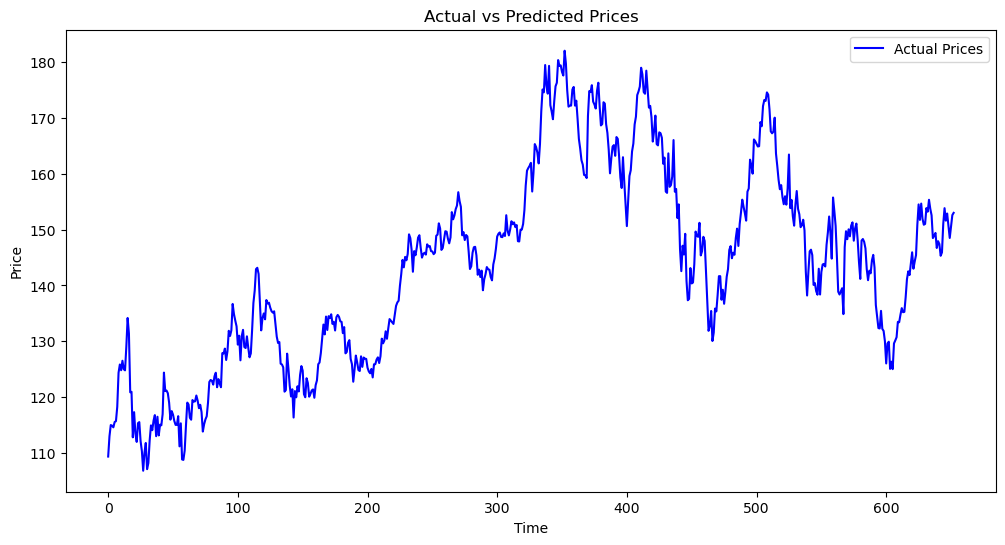

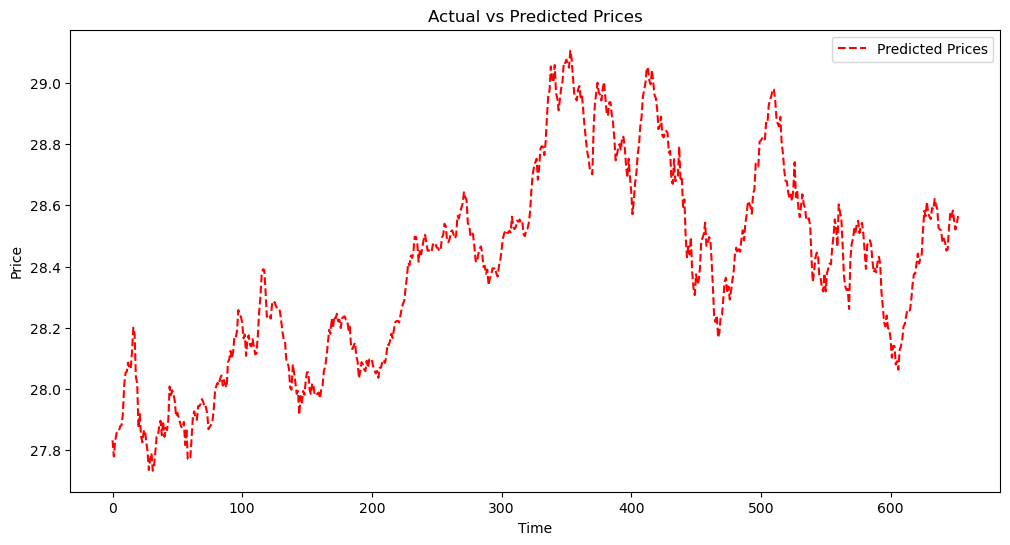

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
#plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
#plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# 10- Model Performance:
There are several metrics to measure the error between the actual prices and the predictions. Some of the most common metrics for regression problems like this are Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

These error metrics provide different perspectives on the prediction errors:

    MSE: Measures the average squared difference between the predicted and actual values. It gives higher weight to larger errors, making it more sensitive to outliers.
    MAE: Measures the average absolute difference between the predicted and actual values. It is less sensitive to outliers than MSE.
    RMSE: Represents the square root of the MSE. It has the same units as the predicted and actual values, making it easier to interpret than MSE. Like MSE, it is sensitive to outliers.
    
By evaluating these error metrics, you can get an understanding of the model's performance and compare it with other models.







In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Mean Squared Error: 13483.63
Mean Absolute Error: 114.85
Root Mean Squared Error: 116.12


Interpreting the error values depends on the context and the scale of the actual stock prices. To better understand if these error values are too large, you can calculate the relative errors by comparing them to the range or the mean of the actual stock prices.

Here's how you can calculate the relative errors:

In [12]:
actual_prices_range = actual_prices.max() - actual_prices.min()
actual_prices_mean = actual_prices.mean()

relative_mse = mse / (actual_prices_range**2)
relative_mae = mae / actual_prices_range
relative_rmse = rmse / actual_prices_range

relative_mae_percentage = (mae / actual_prices_mean) * 100
relative_rmse_percentage = (rmse / actual_prices_mean) * 100

print(f"Relative Mean Squared Error: {relative_mse:.4f}")
print(f"Relative Mean Absolute Error: {relative_mae:.4f}")
print(f"Relative Root Mean Squared Error: {relative_rmse:.4f}")
print(f"Relative Mean Absolute Error (percentage): {relative_mae_percentage:.2f}%")
print(f"Relative Root Mean Squared Error (percentage): {relative_rmse_percentage:.2f}%")


Relative Mean Squared Error: 2.3863
Relative Mean Absolute Error: 1.5279
Relative Root Mean Squared Error: 1.5448
Relative Mean Absolute Error (percentage): 80.17%
Relative Root Mean Squared Error (percentage): 81.06%


# 11- Improving Model by Adding More Layer to Network:

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [14]:
model_n = Sequential()

# First LSTM layer
model_n.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_n.add(Dropout(0.2))

# Second LSTM layer
model_n.add(LSTM(units=100, return_sequences=True))
model_n.add(Dropout(0.2))

# Third LSTM layer
model_n.add(LSTM(units=100))
model_n.add(Dropout(0.2))

# Output layer
model_n.add(Dense(units=1))


In [15]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001  # You can set the desired learning rate value here

optimizer = Adam(lr=learning_rate)

# Compile the model with the custom learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')


/Users/jawadzafar/anaconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
model_n.compile(optimizer='adam', loss='mean_squared_error')
history_n = model_n.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)


In [17]:
predictions_n = model_n.predict(X_test)
predictions_n = predictions_n[:, -1]  # Take the last prediction for each sample
predictions_n = predictions_n.reshape(-1, 1)  # Reshape to (653, 1) before inverse transforming
predictions_n = scaler.inverse_transform(predictions_n)

#actual_prices_n = y_test.reshape(-1, 1)  # Reshape to (num_samples, 1) before inverse transforming
#actual_prices_n = scaler.inverse_transform(actual_prices_n)
#actual_prices_n = actual_prices_n.ravel()  # Flatten the array back to shape (num_samples,)



21/21 [==============================] - 2s 31ms/step


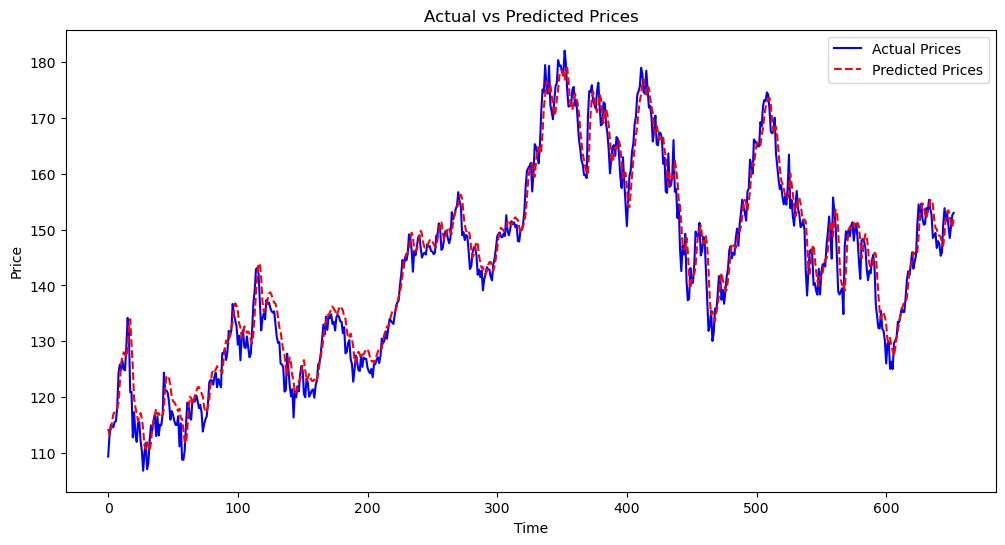

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predictions_n, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()




In [19]:
mse = mean_squared_error(actual_prices, predictions_n)
mae = mean_absolute_error(actual_prices, predictions_n)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

actual_prices_range = actual_prices.max() - actual_prices.min()
actual_prices_mean = actual_prices.mean()

relative_mse = mse / (actual_prices_range**2)
relative_mae = mae / actual_prices_range
relative_rmse = rmse / actual_prices_range

relative_mae_percentage = (mae / actual_prices_mean) * 100
relative_rmse_percentage = (rmse / actual_prices_mean) * 100

print(f"Relative Mean Squared Error: {relative_mse:.4f}")
print(f"Relative Mean Absolute Error: {relative_mae:.4f}")
print(f"Relative Root Mean Squared Error: {relative_rmse:.4f}")
print(f"Relative Mean Absolute Error (percentage): {relative_mae_percentage:.2f}%")
print(f"Relative Root Mean Squared Error (percentage): {relative_rmse_percentage:.2f}%")


Mean Squared Error: 11.56
Mean Absolute Error: 2.64
Root Mean Squared Error: 3.40
Relative Mean Squared Error: 0.0020
Relative Mean Absolute Error: 0.0352
Relative Root Mean Squared Error: 0.0452
Relative Mean Absolute Error (percentage): 1.85%
Relative Root Mean Squared Error (percentage): 2.37%


## Comparison of Both Models:

In [20]:
date_data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')

train_len = len(X_train) + lookback

test_dates = date_data.index[train_len:]

print()


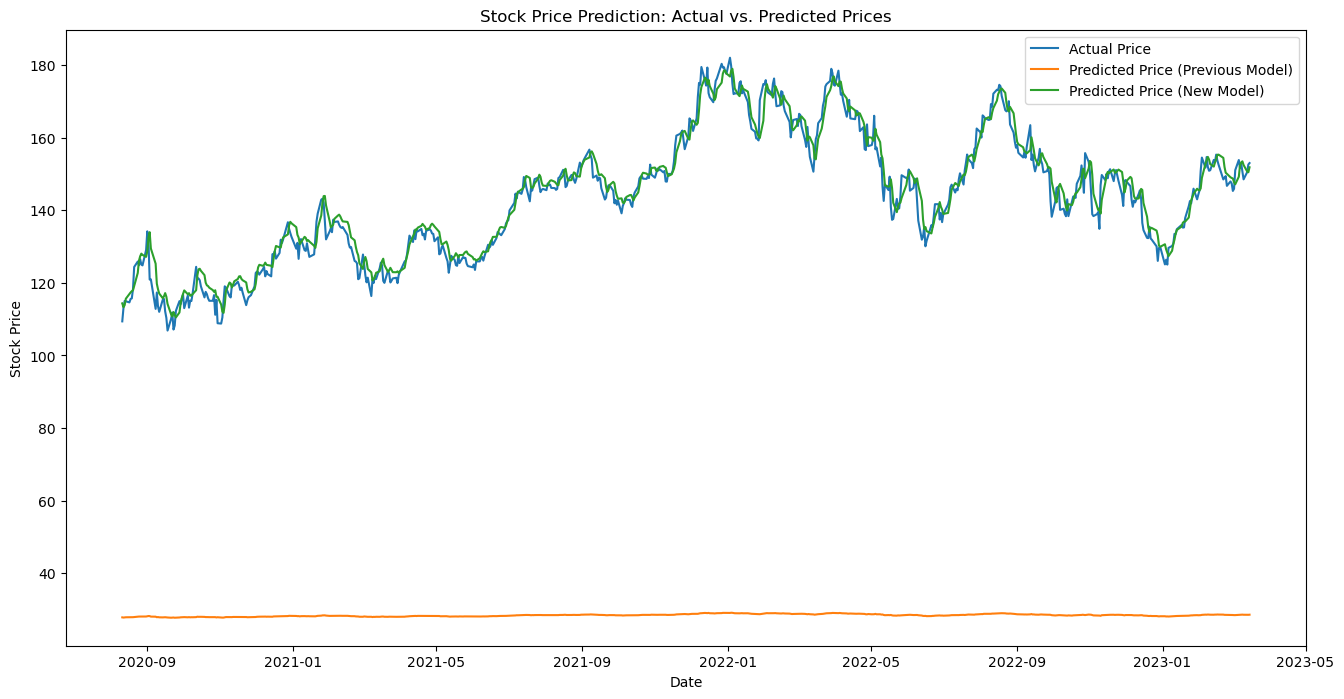

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(test_dates, actual_prices, label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price (Previous Model)')
plt.plot(test_dates, predictions_n, label='Predicted Price (New Model)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction: Actual vs. Predicted Prices')
plt.legend()
plt.show()


# Checking for Over fitting:

To ensure that your model is not overfitting,

## Monitor validation loss:

While training your model, keep track of the validation loss. If the validation loss starts increasing or stagnating while the training loss continues to decrease, it could indicate overfitting. You can modify your model or training process to address this issue.

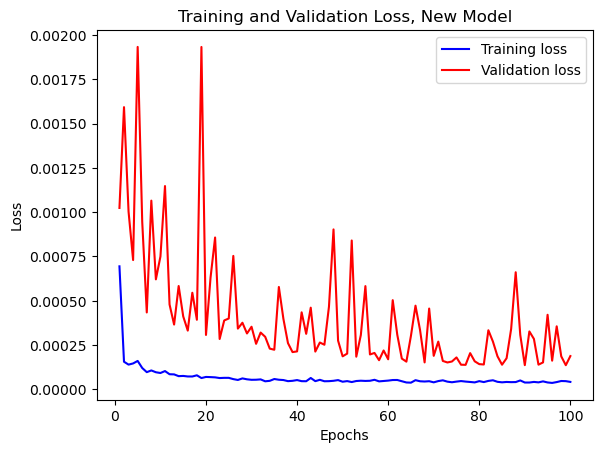

In [22]:

# Get training and validation loss values
train_loss_n = history_n.history['loss']
val_loss_n = history_n.history['val_loss']

# Plot the losses over epochs
epochs = range(1, len(train_loss_n) + 1)
plt.plot(epochs, train_loss_n, 'b', label='Training loss')
plt.plot(epochs, val_loss_n, 'r', label='Validation loss')
plt.title('Training and Validation Loss, New Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Cross-validation Technique: 

Cross-validation is a technique used to assess how well a model generalizes to unseen data. The most common form of cross-validation is k-fold cross-validation. In k-fold cross-validation, the data is divided into k equal-sized folds. The model is then trained on k-1 folds and tested on the remaining fold. This process is repeated k times, with each fold being used as the test set once. The final model performance is calculated as the average performance across all k folds.

In [23]:
from sklearn.model_selection import TimeSeriesSplit

In [24]:
tscv = TimeSeriesSplit(n_splits=5)


In [25]:
mse_scores = []
mae_scores = []
rmse_scores = []


In [26]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build and train the LSTM model as you did previously.
    model_cv = Sequential()
    
    # Add LSTM layers, Dropout, and Dense layers as needed.
    model_cv.add(LSTM(units=40, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_cv.add(Dropout(0.2))
    
    model_cv.add(LSTM(units=40, return_sequences=True))
    model_cv.add(Dropout(0.2))
    
    model_cv.add(LSTM(units=40, return_sequences=False))
    model_cv.add(Dropout(0.2))
    
    model_cv.add(Dense(units=1))

    # Compile the model and fit it to the training data.
    model_cv.compile(optimizer='adam', loss='mean_squared_error')
    model_cv.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Evaluate the model on the test data.
    predictions_cv = model_cv.predict(X_test)
    predictions_cv = scaler.inverse_transform(predictions_cv)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, predictions_cv)
    mae = mean_absolute_error(y_test, predictions_cv)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)


17/17 [==============================] - 1s 16ms/step


In [27]:
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)


print(f"Relative Mean Squared Error: {avg_mse:.4f}")
print(f"Relative Mean Absolute Error: {avg_mae:.4f}")
print(f"Relative Root Mean Squared Error: {avg_rmse:.4f}")


Relative Mean Squared Error: 10.5783
Relative Mean Absolute Error: 1.9268
Relative Root Mean Squared Error: 2.5283
